In [21]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'



import numpy as np
import jax
import jax.numpy as jnp
from classy import Class    # CLASS python
import jax_cosmo as jc      # Jax-cosmo lib
import pyccl as ccl         # CCL python
import jemupk  as emu  # Jax Emulator of CLASS

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
import matplotlib.patches as mpatches
mpl.rcParams['font.size'] = 20

In [23]:
import settings_gfpkq_120x20  as st         # configuration file (update 2/June/22)

In [24]:
print(f"(k,z)-grid: {st.nk}x{st.nz}")

(k,z)-grid: 120x20


In [25]:
root_dir = "./"
if st.sigma8:
    print("Using: Omega_cdm, Omega_b, sigma8, ns, h")
    tag='_Omega_sig8_'  + str(st.nk) + "x" + str(st.nz)  
else:
    raise NotImplementedError("No more in use")

load_dir = root_dir + '/pknl_components' + st.d_one_plus+tag

Using: Omega_cdm, Omega_b, sigma8, ns, h


In [26]:
# load GP material
gp_factory = emu.GP_factory.make(load_dir)

In [27]:
jc.Planck15()

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

In [28]:
cosmo_jc = jc.Planck15()

In [29]:
h_emu = cosmo_jc.h
Omega_c_emu =  cosmo_jc.Omega_c
Omega_b_emu = cosmo_jc.Omega_b
sigma8_emu = cosmo_jc.sigma8
n_s_emu = cosmo_jc.n_s

cosmo_ccl = ccl.Cosmology(
    Omega_c=Omega_c_emu, Omega_b=Omega_b_emu, 
    h=h_emu, n_s=n_s_emu, sigma8 = sigma8_emu,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')


In [30]:
cosmo_ccl

pyccl.Cosmology(Omega_c=0.2589, Omega_b=0.0486, h=0.6774, n_s=0.9667, sigma8=0.8159, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, c1_mg=1.0, c2_mg=1.0, lambda_mg=0.0, extra_parameters=None, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [31]:
cosmo_jax = jc.Cosmology(Omega_c=Omega_c_emu, Omega_b=Omega_b_emu, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Omega_k=0.0, w0=-1.0,wa=0.0)

# Test multi redshifts Pk computations

In [32]:
Nk=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.k_max_h_by_Mpc, Nk, endpoint=True) #h/Mpc
z_star = jnp.array([0.,1., 2., 3.])

In [33]:
%time pk_linear_interp = emu.linear_pk(cosmo_jax, k_star,z_star)

2022-07-05 14:48:54.996597: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[16,4800]{1,0} custom-call(f64[16,16]{1,0} %multiply.16, f64[16,4800]{1,0} %concatenate.744), custom_call_target="__cublas$gemm", metadata={op_type="dot_general" op_name="jit(jec_interp2d_v2)/dot_general[\n  dimension_numbers=(((1,), (0,)), ((), ()))\n  precision=None\n  preferred_element_type=None\n]" source_file="/sps/lsst/users/campagne/Jemu/util.py" source_line=82}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"256\",\"rhs_stride\":\"76800\"}" failed. Falling back to default algorithm. 


In [34]:
%time pk_nonlin_interp = emu.nonlinear_pk(cosmo_jax,k_star, z_star) 

CPU times: user 1min 1s, sys: 4.45 s, total: 1min 6s
Wall time: 56.6 s


In [35]:
%timeit pk_linear_interp = emu.linear_pk(cosmo_jax, k_star,z_star)

3.5 ms ± 55.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%timeit pk_nonlin_interp = emu.nonlinear_pk(cosmo_jax,k_star, z_star) 

4.16 ms ± 4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
pk_linear_interp.shape, pk_nonlin_interp.shape

((4, 1200), (4, 1200))

In [38]:
# CCL & Jax-cosmo

In [39]:
zbin=2
z_ccl = z_star[zbin].item()

print("z_ccl=",z_ccl)

z_ccl= 2.0


In [40]:
# Classy

In [41]:
st.fixed_nm['M_tot']

0.06

In [42]:
params_def_classy = {
    'output': 'mPk',
    'n_s': n_s_emu, 
    'h': h_emu,
    'Omega_b': Omega_b_emu,
    'Omega_cdm':Omega_c_emu,
    'N_ncdm': 1.0, 
    'deg_ncdm': 3.0, 
    'T_ncdm': 0.71611, 
    'N_ur': 0.00641,
    'm_ncdm':0.02,
    'z_max_pk' :  st.zmax,
    'P_k_max_h/Mpc' : 500.,
    'halofit_k_per_decade' : 80.,
    'halofit_sigma_precision' : 0.05
    }

if st.sigma8:
    params_def_classy['sigma8']=sigma8_emu
else:
    raise NotImplementedError("No more in use") #params_def_classy['A_s']=As_emu,

#Neutrino default
params_def_classy['m_ncdm'] = st.fixed_nm['M_tot']/params_def_classy['deg_ncdm']


params_classy_lin =  params_def_classy.copy()
params_classy_lin['non_linear'] = 'none'

params_classy_nl =  params_def_classy.copy()
params_classy_nl['non_linear'] = 'halofit'

In [43]:
# Clean CLASS memory
try:
    class_module_lin.struct_cleanup()
    class_module_lin.empty()
    class_module_nl.struct_cleanup()
    class_module_nl.empty()
except:
    pass

In [44]:
class_module_nl = Class()
class_module_nl.set(params_classy_nl)
class_module_nl.compute()

In [45]:
pk_class_lin = np.array([class_module_nl.pk_lin(k * h_emu, z_ccl) for k in k_star])
pk_lin_ccl = ccl.linear_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 1./(1+z_ccl)) #last is scale factor 1=>z=0
pk_lin_jc = jc.power.linear_matter_power(cosmo_jax,k_star, 1./(1+z_ccl))/cosmo_jax.h**3

In [46]:
pk_class_nl  = np.array([class_module_nl.pk(k * h_emu, z_ccl) for k in k_star])

pk_nonlin_ccl = ccl.nonlin_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 
                                        1./(1+z_ccl)) #last is scale factor 1=>z=0


pk_nonlin_jc = jc.power.nonlinear_matter_power(cosmo_jax,k_star, 
                                               1./(1+z_ccl))/cosmo_jax.h**3

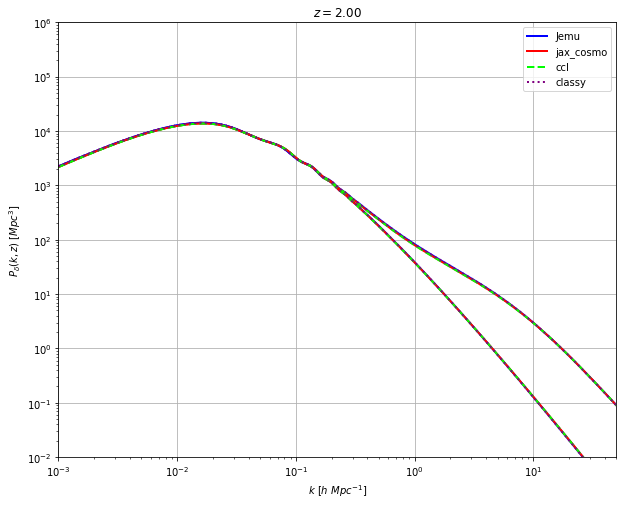

In [59]:
plt.figure(figsize=(10,8))

plt.plot(k_star,pk_linear_interp[zbin,:],lw=2, c="b", label="Jemu")
plt.plot(k_star,pk_lin_jc,lw=2, c="r", label="jax_cosmo")
plt.plot(k_star,pk_lin_ccl,lw=2, ls="--", c="lime", label=r"ccl")
plt.plot(k_star,pk_class_lin,lw=2, ls=":", c="purple",label="classy")



plt.plot(k_star,pk_nonlin_interp[zbin],lw=2, c="b")#, label=r"$P_{{nl}}$ (Jemu)")
plt.plot(k_star,pk_nonlin_jc,lw=2, c="r")#, label=r"$P_{{nl}}$ (jax_cosmo)")
plt.plot(k_star,pk_nonlin_ccl,lw=2, ls="--",c="lime")#,label=r"$P_{{nl}}$ (ccl)")
plt.plot(k_star,pk_class_nl,lw=2, ls=":", c="purple")#,label="classy")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z)\ [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_ccl:.2f}$");
plt.xlim([1e-3,5e1])
plt.ylim([1e-2,1e6]);

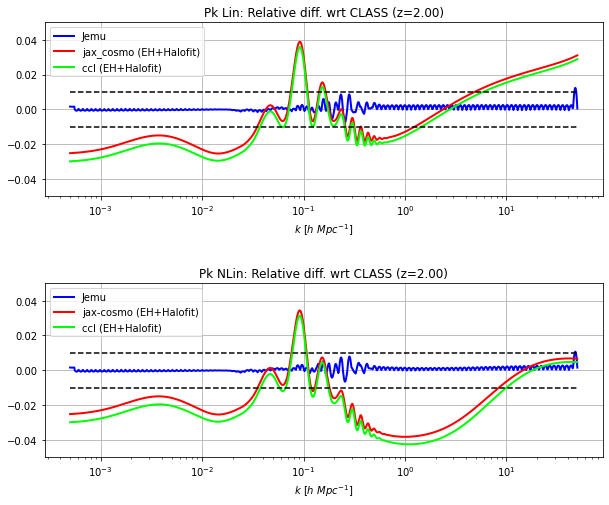

In [49]:
fig, axs= plt.subplots(nrows=2,figsize=(10,8), gridspec_kw={"hspace":0.5})
axs[0].plot(k_star,(pk_linear_interp[zbin,:]-pk_class_lin)/pk_class_lin,lw=2, c="b", label="Jemu")
axs[0].plot(k_star,(pk_lin_jc-pk_class_lin)/pk_class_lin,lw=2, c="r", label="jax_cosmo (EH+Halofit)")
axs[0].plot(k_star,(pk_lin_ccl-pk_class_lin)/pk_class_lin,lw=2, c="lime", label="ccl (EH+Halofit)")
axs[0].legend(loc='upper left')
axs[0].grid()
axs[0].set_xscale("log");

axs[0].set_ylim([-0.05,0.05])
axs[0].plot([k_star.min(),k_star.max()],[-0.01,-0.01],c='k',ls='--')
axs[0].plot([k_star.min(),k_star.max()],[0.01,0.01],c='k',ls='--')
axs[0].set_xlabel(r"$k\ [h\ Mpc^{-1}]$")

axs[0].set_title(f"Pk Lin: Relative diff. wrt CLASS (z={z_ccl:.2f})");


axs[1].plot(k_star,(pk_nonlin_interp[zbin]-pk_class_nl)/pk_class_nl,lw=2, c="b", label="Jemu")#, label=r"$P_{{nl}}$ (Jemu)")
axs[1].plot(k_star,(pk_nonlin_jc-pk_class_nl)/pk_class_nl,lw=2, c="r", label="jax-cosmo (EH+Halofit)")#, label=r"$P_{{nl}}$ (jax_cosmo)")
axs[1].plot(k_star,(pk_nonlin_ccl-pk_class_nl)/pk_class_nl,lw=2,c="lime",  label="ccl (EH+Halofit)")#,label=r"$P_{{nl}}$ (ccl)")
axs[1].grid()
axs[1].legend(loc='upper left')
axs[1].set_xscale("log")
axs[1].set_ylim([-0.05,0.05])
axs[1].plot([k_star.min(),k_star.max()],[-0.01,-0.01],c='k',ls='--')
axs[1].plot([k_star.min(),k_star.max()],[0.01,0.01],c='k',ls='--')
axs[1].set_xlabel(r"$k\ [h\ Mpc^{-1}]$")

axs[1].set_title(f"Pk NLin: Relative diff. wrt CLASS (z={z_ccl:.2f})");


# Jacobians & vectorization

In [50]:
jc_func_nl = lambda p: jc.power.nonlinear_matter_power(p,k_star, 1./(1+z_ccl))/p.h**3
jac_jc_func_nl = jax.jacfwd(jc_func_nl)(cosmo_jax)

In [51]:
func_nl = lambda p: emu.nonlinear_pk(p,k_star, z_star=z_ccl)
jac_nonlin_emu = jax.jacfwd(func_nl)(cosmo_jax)

2022-07-05 14:54:36.414923: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-batch-gemm.1 = f64[120,8,5]{2,1,0} custom-call(f64[120,8,5]{2,1,0} %bitcast.39, f64[120,5,5]{2,1,0} %constant.45951), custom_call_target="__cublas$gemm", backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"2\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[\"0\"],\"rhs_batch_dimensions\":[\"0\"]},\"batch_size\":\"120\",\"lhs_stride\":\"40\",\"rhs_stride\":\"25\"}" failed. Falling back to default algorithm. 
2022-07-05 14:54:36.420044: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-batch-gemm.3 = f64[12

### Notice that the emulator has a fixed (Omega_k, w0, wa) values so the gradients are not relevant for these parameters 

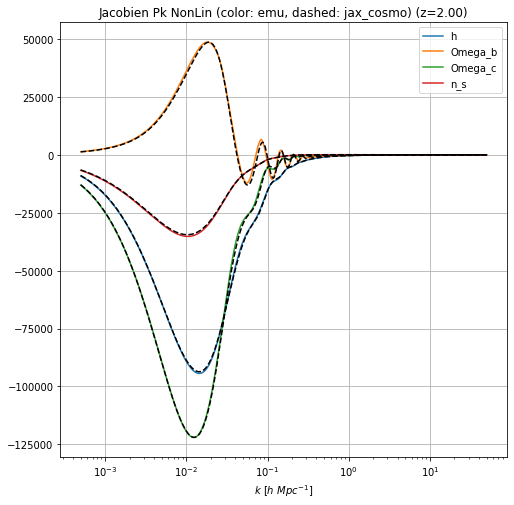

In [52]:
# Omega_c, Omega_b, h, n_s, sigma8, Omega_k, w0, wa, gamma=None
titles=f"Jacobien Pk NonLin (color: emu, dashed: jax_cosmo) (z={z_ccl:.2f})"
lines=["-","--"]
colors=[None,"k"]
fig = plt.figure(figsize=(8,8))
for i,jaco in enumerate([jac_nonlin_emu, jac_jc_func_nl]):
    plt.plot(k_star,jaco.h,label="h",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.Omega_b,label="Omega_b",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.Omega_c,label="Omega_c",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.n_s,label="n_s",c=colors[i],ls=lines[i])
    if i == 0:
        plt.legend();
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")
plt.xscale("log")
plt.title(titles)
plt.grid()

In [53]:
# Omega_c, Omega_b, h, n_s, sigma8, Omega_k, w0, wa, gamma=None
Omega_c_arr = jnp.linspace(cosmo_jax.Omega_c*0.5,cosmo_jax.Omega_c*1.5,10)
axes = jc.Cosmology(Omega_c=0,
                    Omega_b=None,h=None,n_s=None,sigma8=None,Omega_k=None,w0=None,wa=None,gamma=None)

In [54]:
pk_nonlin_Omegac_jc = jax.vmap(jc_func_nl, in_axes=(axes,))(
    jc.Cosmology(
        Omega_c=Omega_c_arr,
        Omega_b=cosmo_jax.Omega_b,
        h=cosmo_jax.h,
        n_s=cosmo_jax.n_s,
        sigma8=cosmo_jax.sigma8,
        Omega_k=cosmo_jax.Omega_k,
        w0=cosmo_jax.w0,
        wa=cosmo_jax.wa,
        gamma=cosmo_jax.gamma))

In [55]:
pk_nonlin_Omegac_emu = jax.vmap(func_nl, in_axes=(axes,))(
    jc.Cosmology(
        Omega_c=Omega_c_arr,
        Omega_b=cosmo_jax.Omega_b,
        h=cosmo_jax.h,
        n_s=cosmo_jax.n_s,
        sigma8=cosmo_jax.sigma8,
        Omega_k=cosmo_jax.Omega_k,
        w0=cosmo_jax.w0,
        wa=cosmo_jax.wa,
        gamma=cosmo_jax.gamma))

2022-07-05 14:57:17.517708: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-batch-gemm.1 = f64[120,10,5]{2,1,0} custom-call(f64[120,10,5]{2,1,0} %bitcast.13, f64[120,5,5]{2,1,0} %constant.630), custom_call_target="__cublas$gemm", backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"2\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[\"0\"],\"rhs_batch_dimensions\":[\"0\"]},\"batch_size\":\"120\",\"lhs_stride\":\"50\",\"rhs_stride\":\"25\"}" failed. Falling back to default algorithm. 
2022-07-05 14:57:17.523605: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:211] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-batch-gemm.3 = f64[12

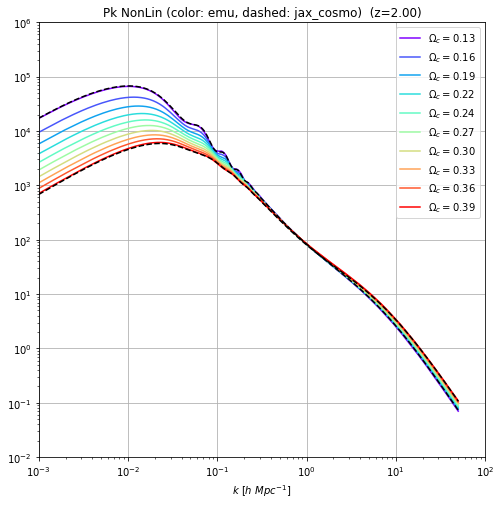

In [56]:
titles=f"Pk NonLin (color: emu, dashed: jax_cosmo)  (z={z_ccl:.2f})"
fig = plt.figure(figsize=(8,8))
for iax,pk_emu in enumerate([pk_nonlin_Omegac_emu, pk_nonlin_Omegac_jc]):
    color = iter(mpl.cm.rainbow(np.linspace(0, 1, pk_emu.shape[0])))
    for i in range(pk_emu.shape[0]):
        if iax==0:
            c = next(color)
            plt.plot(k_star,pk_emu[i,:],c=c,label=fr"$\Omega_c=${Omega_c_arr[i]:.2f}");
        else:
            if i==0 or i==pk_emu.shape[0]-1:
                plt.plot(k_star,pk_emu[i,:],c='k',ls='--')
plt.xscale("log")
plt.yscale("log")
plt.title(titles)
plt.grid()
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])
plt.legend()
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$");